# Snapshot Demo: Cycle and Lemniscate Graphs

This notebook demonstrates the enhanced snapshot capture pipeline for PropFlow's belief propagation engine. We build a cycle graph and a lemniscate (∞) graph, run short simulations with snapshots enabled, and inspect the captured artefacts.


In [1]:
from __future__ import annotations

from datetime import datetime
from pathlib import Path
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from propflow.bp.engine_base import BPEngine
from propflow.configs import create_random_int_table
from propflow.snapshots.utils import latest_snapshot
from propflow.utils.fg_utils import FGBuilder


In [2]:
RUN_ROOT = Path("results/notebooks/snapshot_demo")
RUN_ROOT.mkdir(parents=True, exist_ok=True)
np.random.seed(7)


def _plot_factor_graph(graph, ax, title: str) -> None:
    labels = {node: getattr(node, "name", str(node)) for node in graph.G.nodes}
    pos = nx.spring_layout(graph.G, seed=42)
    var_nodes = list(graph.variables)
    fac_nodes = list(graph.factors)
    ax.set_title(title)
    ax.axis("off")
    nx.draw_networkx_nodes(graph.G, pos, nodelist=var_nodes, node_color="#4c72b0", node_size=600, ax=ax, label="Variables")
    nx.draw_networkx_nodes(graph.G, pos, nodelist=fac_nodes, node_color="#dd8452", node_shape="s", node_size=500, ax=ax, label="Factors")
    nx.draw_networkx_edges(graph.G, pos, ax=ax, alpha=0.3)
    nx.draw_networkx_labels(graph.G, pos, labels=labels, font_size=10, ax=ax)
    ax.legend(loc="upper right")


def _run_demo(label: str, graph, max_steps: int = 6):
    run_dir = RUN_ROOT / f"{label}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir.mkdir(parents=True, exist_ok=True)


    engine = BPEngine(
        factor_graph=graph,
        use_bct_history=True,
    )
    engine.run(max_iter=max_steps)

    return engine


def _load_latest_meta(result: dict) -> dict:
    manifest = result["manifest"]
    if not manifest.get("steps"):
        return {}
    last_step = manifest["steps"][-1]["step"]
    meta_path = result["run_dir"] / f"step_{int(last_step):04d}" / "meta.json"
    if meta_path.exists():
        return json.loads(meta_path.read_text())
    return {}


In [3]:
cycle_graph = FGBuilder.build_cycle_graph(
    num_vars=6,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)
cycle_result = _run_demo("cycle", cycle_graph, max_steps=6)



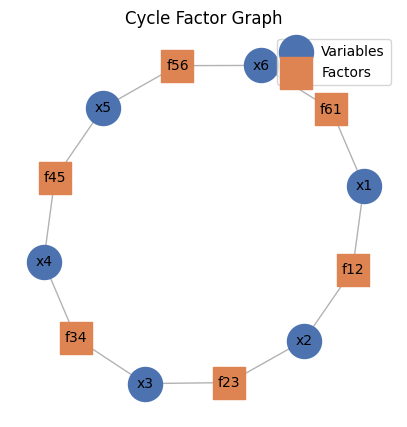

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
_plot_factor_graph(cycle_graph, ax, "Cycle Factor Graph")
plt.show()



In [5]:
lemn_graph = FGBuilder.build_lemniscate_graph(
    num_vars=8,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)
lemn_result = _run_demo("lemniscate", lemn_graph, max_steps=8)


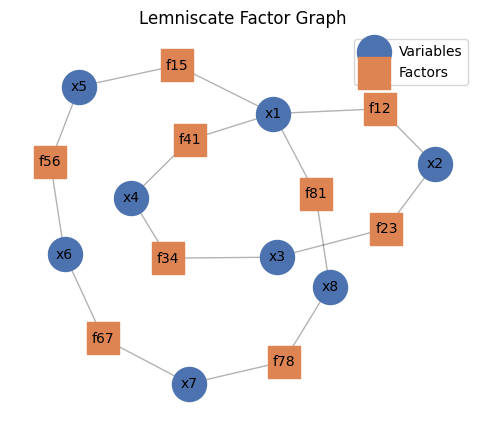

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
_plot_factor_graph(lemn_graph, ax, "Lemniscate Factor Graph")
plt.show()
snapshots = lemn_result.snapshots

/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:931: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:651: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:871: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


BCTCreator initialized:
  - BCT mode: True
  - Variables tracked: 8
  - Message flows: 36
  - Total steps: 8


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/utils/tools/bct.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


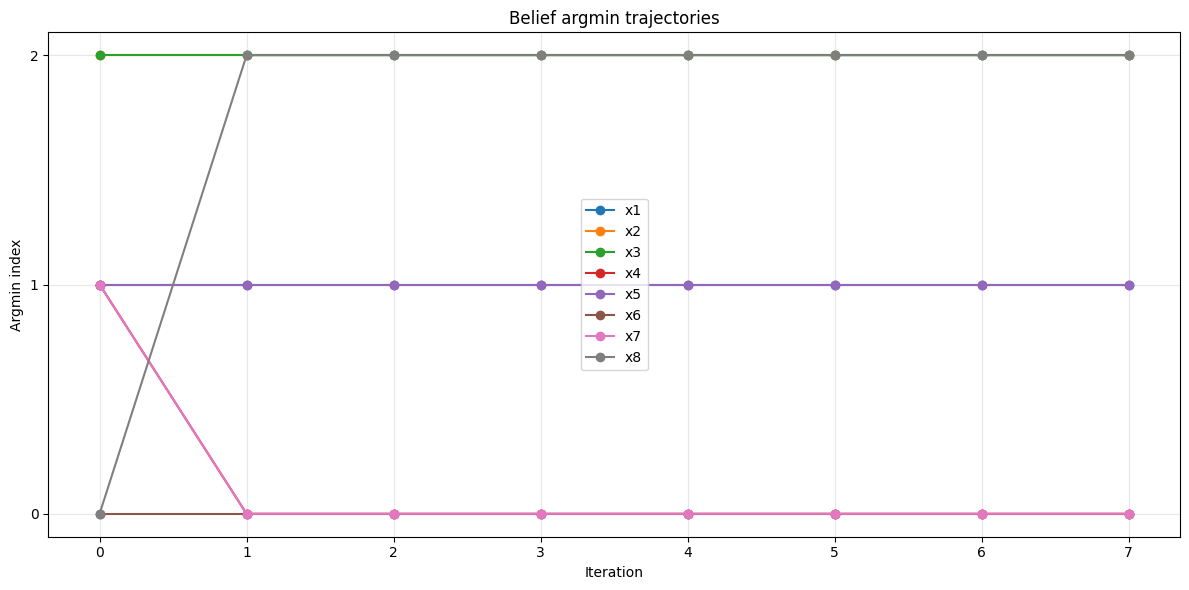

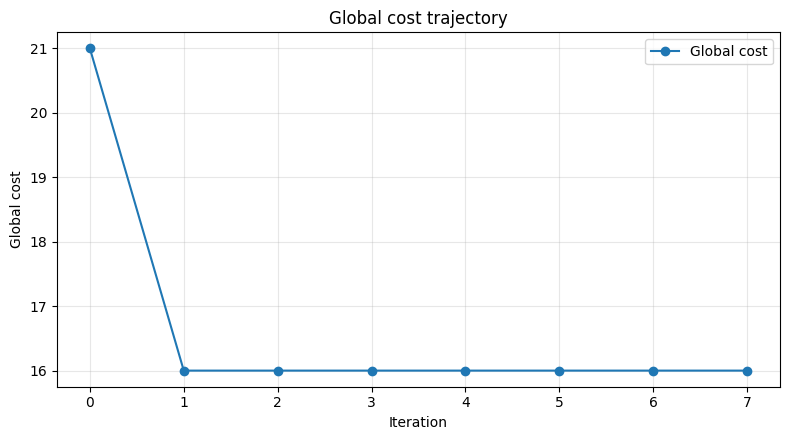

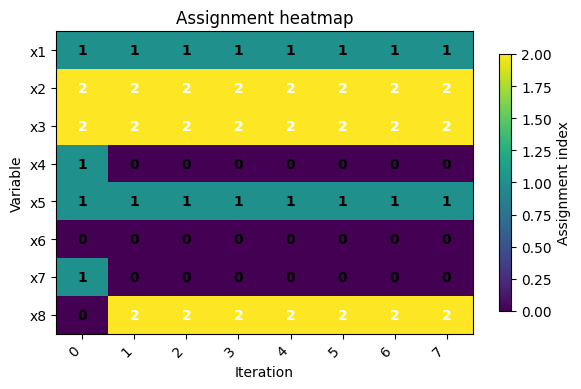

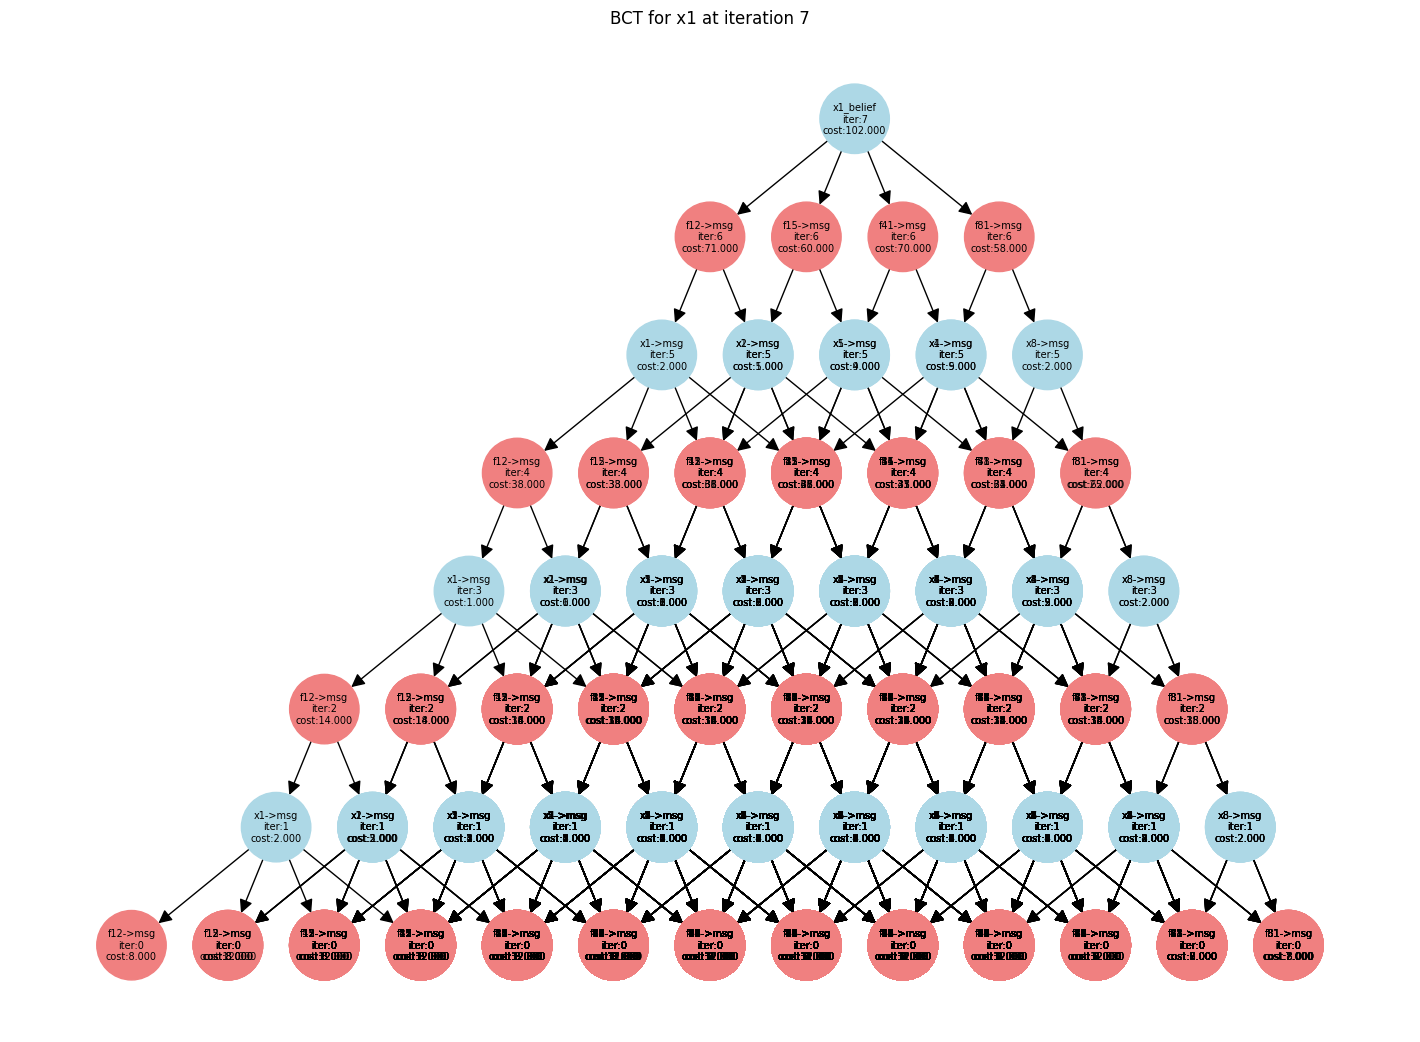

In [7]:
from propflow.snapshots.visualizer import SnapshotVisualizer


viz = SnapshotVisualizer(snapshots=snapshots)
viz.plot_argmin_per_variable(layout = "combined")
viz.plot_global_cost()
viz.plot_assignment_heatmap()
viz.plot_bct("x1")